[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/laiadc/MachineLearningHandsOn/blob/main/day3/Ethics%20and%20sentiment%20analysis.ipynb)

# Ethics in Sentiment Analysis

A very popular field in machine learning is natural language processing (NLP). This field is devoted to extract valuable information from text. Examples of applications of NLP are data translation ([google translaor](https://translate.google.es/?hl=ca) is an example, even though you can do much better), gramatical correction, summarizing text, etc. All these applications have something in common: they work with words. 



## Woking with words

In order to use a machine learning method to work with words and text, we need to give the words to the model in a way it can understand them. Machine learning models can not work with words directly, they need the words to be represented as a vector of fixed length.

For example, the word "apple" could be represented as a vector or *embedding*:

$$
embedding(\text{apple}) = \left[ \begin{array}{c} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{array} \right]
$$

In general, if we have a set $V$ of words, we would represent the words as a matrix (or simply a table):

$$
\begin{matrix}
word_1: \\
word_2:\\
\vdots\\
word_{|V|}: \\
\end{matrix}
\left[
\begin{matrix}
x_{1,1}&x_{1,2}& \dots &x_{1,n}\\
x_{2,1}&x_{2,2}& \dots &x_{2,n}\\
\vdots&&\\
x_{{|V|},1}&x_{{|V|},2}& \dots &x_{{|V|},n}\\
\end{matrix}
\right]
$$

The job of data scientists is to find the representation of words as vectors which is more useful for the machine learning models.

## One-hot encoding

The simplest way to associate words with vectors is to use the one-hot encoding technique. Ee represent every word as an vector with all $0$s and one $1$ at the index of that word in the sorted english language. Word vectors in this type of encoding would appear as the following:

<centering>
$$w^{aardvark} = \left[ \begin{array}{c} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{array} \right], w^{a} = \left[ \begin{array}{c} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{array} \right] , w^{at} = \left[ \begin{array}{c} 0 \\ 0 \\ 1 \\ \vdots \\ 0 \end{array} \right] , \cdots,  w^{zebra} = \left[ \begin{array}{c} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{array} \right] $$
</centering>


We represent each word as a completely independent entity:

$$(w^{hotel})^Tw^{motel} = (w^{hotel})^Tw^{cat} = 0$$

What is the problem with this approach? 
1. There are around ~ 500.000 words in English (~100.000 in Spanish), and therefore every vector is way too large.

2. Not all the words are equally common in texts (words like "él", "la", "uno" are much more frequent than "electrocardiograma" in Spanish, for instance). Then, should all the words have the same importance? 

3. We are not taking into account gramatical and semantical rules. Words are not independent from each other. For example, the sentence "*María fue a comprar patatas*" is much more frequent than "*Comer silla es juguete*", which has no meaning. 

Luckily, deep learning models are able to take all these issues into account and design more useful word embeddings. 


## Word embeddings

Modern word embeddings assume that words that are related will often appear in the same documents (or sentences, paragraphs, etc.).

For instance, "banco", "dinero", "inversiones", "deudad", etc. are probably likely to appear together. But "banco", "pulpo", "plátano", and "hockey" would probably not consistently appear together. These models use complex algorithms which allow to represent each word as a vector which encodes information about the probability of appearing next to other words, the popularity of this word and the gramatical and semantical rules of the language. As you can imagine, this is not an easy task. 


There are several datasets of pre-trained English word embeddings such as `word2vec`, pretrained on Google News data, and `GloVe`, pretrained on the Common Crawl of web pages. We will use `GloVe`.


## Load the embeddings

The following code downloads the data to create the embeddings from words.

In [1]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2021-05-06 14:50:34--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2021-05-06 14:50:34--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2021-05-06 14:50:34--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [1]:
!unzip glove.42B.300d.zip

"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def load_embeddings(filename):
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in tqdm(enumerate(infile)):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('glove.42B.300d.txt')
embeddings.shape

1917494it [02:49, 11326.67it/s]


(1917494, 300)

# Sentiment analysis

In this example we will use the word embeddings to perform what is called sentiment analysis. This technique consists of assigning a value to each word. Positive values refer to positive words (such as "happy", "good", "awesome", etc.) and negative values refer to bad words (such as "hard", "sad", "boring", etc.) Values close to zero refer to neutral words. This method can be used to automatically asses product reviews just by reading the text. 

The next cells show the steps to create a simple model to perform sentiment analysis.

## Positive and Negative Words

We need some input about which words are positive and which words are negative. There are many sentiment lexicons you could use, but we’re going to go with a very straightforward lexicon from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html  

There is a copy of these files in the GitHub repository of the course.

In [4]:
!wget 'https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster20192020/master/data/positive-words.txt'

!wget 'https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster20192020/master/data/negative-words.txt'

--2021-05-06 15:03:54--  https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster20192020/master/data/positive-words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22408 (22K) [text/plain]
Saving to: ‘positive-words.txt’

positive-words.txt  100%[===================>]  21.88K  --.-KB/s    in 0.001s  

2021-05-06 15:03:54 (33.4 MB/s) - ‘positive-words.txt’ saved [22408/22408]

--2021-05-06 15:03:54--  https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster20192020/master/data/negative-words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent,

In [5]:
def load_lexicon(filename):
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('positive-words.txt')
neg_words = load_lexicon('negative-words.txt')

Some of these words are not in the GloVe vocabulary. We have to remove them so that we do not have errors.

In [6]:
pos_vectors = embeddings.loc[embeddings.index.intersection(pos_words)]
neg_vectors = embeddings.loc[embeddings.index.intersection(neg_words)]

Here we can see an example of positive and negative words, together with their respective embeddings. Notice that each word is represented as a vector (the row of the table) of 300 points.

In [13]:
print('POSITIVE WORDS')
pos_vectors.head()

POSITIVE WORDS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
like,-0.014949,0.17910,-0.288830,-0.33999,-0.030165,0.000576,-4.0142,-0.561890,-0.245360,-0.90196,0.426050,0.30041,0.32461,-0.094574,-0.133660,-0.049502,-0.249840,0.023725,-0.397180,0.172910,0.062534,-0.34646,0.296720,-0.119390,0.13938,-0.505840,-0.215180,-0.730680,-0.051667,-0.069903,-0.071621,0.389340,0.170070,0.190840,0.040775,0.001309,0.327190,-0.311380,0.34084,-0.180780,...,-0.27485,-0.234080,0.334140,-0.336470,-0.099405,-0.112080,-0.272000,0.140510,-0.188090,0.025763,0.038478,0.008336,-0.42713,-0.216490,0.030883,-0.232090,0.186090,0.342090,0.097109,-0.166160,1.135300,0.186620,0.22876,0.081640,0.089013,-0.14447,0.064785,0.010417,0.250460,-0.06917,0.213020,-0.040679,-0.346990,-0.315360,0.47710,-0.234870,-0.33792,0.059178,-0.192210,0.456200
good,-0.069254,0.37668,-0.169580,-0.27482,0.256670,-0.202930,-4.1122,0.025950,-0.270850,-0.87003,-0.010262,-0.10048,-0.06171,-0.211100,-0.376520,0.104460,0.054106,-0.252250,-0.125050,-0.134610,0.340040,-0.28599,0.048589,-0.088778,-0.10750,-0.411750,-0.153960,0.043628,0.256900,0.072977,0.005422,0.178690,0.033359,-0.147760,0.296360,-0.022996,-0.147270,-0.131910,-0.10101,-0.087417,...,0.15689,0.095238,0.299280,-0.133760,0.512290,-0.058114,0.051375,-0.379820,-0.099555,0.098564,-0.196080,0.449200,-0.20517,-0.041098,-0.273480,0.059709,-0.261000,0.054030,-0.367590,0.127250,0.678610,-0.463270,0.17716,0.342190,0.490060,0.47282,-0.039460,0.393040,-0.023976,-0.60973,-0.484760,-0.333630,-0.075956,0.158270,0.29431,-0.074275,-0.28909,-0.220280,0.088971,-0.028352
well,0.088205,0.40155,-0.044703,-0.50973,0.116040,-0.161300,-4.3066,-0.084823,0.088231,-0.59067,0.050804,0.15545,0.20166,0.125620,-0.243730,-0.338920,-0.103340,-0.231480,-0.076147,0.166520,0.042690,0.19294,0.159880,-0.055858,-0.13619,-0.304690,0.258080,-0.337290,0.374110,0.215360,-0.122770,-0.045159,0.127970,-0.035766,-0.004277,-0.490100,-0.070168,-0.030209,0.16469,-0.184570,...,0.12287,-0.040766,-0.038844,-0.412460,0.298020,-0.149480,-0.148860,0.038524,-0.270100,-0.128980,-0.007672,0.031855,-0.13574,0.018512,-0.067022,0.256120,-0.321570,0.069910,-0.165410,-0.058677,0.627350,-0.440770,0.22677,0.179880,0.251690,0.45095,-0.105110,0.191540,0.038259,-0.21491,0.042501,-0.043897,-0.550510,-0.274440,0.31041,-0.230230,-0.24066,0.046184,0.079135,0.095058
great,-0.033819,0.27263,-0.203010,-0.29310,0.104890,-0.211420,-3.5503,-0.633350,-0.282800,-0.45047,-0.366120,-0.15207,0.20128,0.186320,-0.073614,-0.083101,0.079977,-0.172940,0.063676,0.141480,0.495160,0.19244,0.056514,0.077089,0.11047,-0.233730,0.251210,0.360610,-0.048826,0.187960,-0.090890,0.133780,0.354210,0.330030,0.116130,-0.364060,-0.053876,-0.244510,0.55024,-0.230970,...,0.31822,0.234780,0.146620,-0.059459,0.344960,-0.413130,0.041587,0.030463,-0.414440,0.016954,-0.196070,0.445080,-0.48607,-0.345130,-0.153900,0.018211,0.056174,0.124790,-0.136790,0.031663,0.720310,-0.091717,0.11960,0.270430,-0.022466,0.55137,-0.138640,0.140370,-0.217250,-0.31669,-0.173440,-0.237840,-0.241870,-0.012594,0.23626,-0.152350,-0.21312,-0.184580,0.024633,0.039906
free,-0.619840,-0.31242,0.399180,0.48442,0.174360,0.424940,-3.1734,0.094000,-0.455390,-0.65336,0.170440,-0.11730,0.55500,0.213810,-0.179440,0.177990,-0.412120,0.339260,-0.305810,0.026446,0.050631,0.17718,-0.253260,-0.148710,0.38141,0.029286,-0.021158,-0.579240,0.375810,-0.642010,0.078625,0.240960,0.864620,-0.309520,-0.165320,-0.207650,-0.034054,-0.059644,-0.32430,0.309630,...,0.27342,0.239320,-0.123590,0.251170,-0.267460,-0.009448,-0.161960,0.271720,-0.317610,0.574420,-0.168850,0.306540,0.22519,0.005495,-0.739160,-0.121870,0.633160,0.082624,1.259500,0.097352,-0.069293,0.091564,-0.77943,-0.073698,-0.128180,0.12361,0.035258,-0.494880,0.905790,0.47882,-0.318380,-0.287080,0.174230,0.069032,-0.54077

In [14]:
print('NEGATIVE WORDS')
neg_vectors.head()

NEGATIVE WORDS


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
hard,-0.380650,0.332450,0.053904,0.199670,-0.031819,-0.48597,-3.8727,0.14551,-0.307920,-0.73145,0.620760,-0.25283,0.19368,-0.612000,0.182140,0.50387,-0.080498,-0.523260,-0.607350,0.254800,-0.11780,0.065659,0.140310,-0.12898,-0.26162,-0.091026,-0.041549,-0.18930,0.116160,0.189510,0.14205,-0.002358,-0.12047,-0.510650,0.019839,0.483200,0.063296,0.05119,-0.716130,0.194310,...,0.042888,-0.19716,-0.679420,-0.58452,0.13436,-0.065681,-0.286690,-0.313940,0.076297,0.455970,0.156790,0.26614,-0.102740,-0.023730,0.327520,0.10950,0.20824,0.21859,0.084789,-0.082523,0.82005,0.250770,0.281840,0.390730,-0.28449,0.034170,0.016893,0.41290,0.251210,-0.452410,0.24153,0.027313,-0.20323,-0.264750,0.072299,0.373390,0.278730,0.086626,0.33142,0.201400
bad,0.008644,-0.186530,-0.507370,0.082950,-0.318540,0.14439,-3.7237,0.24818,0.282390,-0.69299,0.547180,0.21330,-0.12298,-0.367120,-0.067024,0.47459,0.064185,0.019239,-0.519690,-0.063528,0.11405,0.059072,0.362800,0.21275,-0.28035,-0.101910,-0.319050,-0.25206,0.235390,0.406310,-0.11798,0.007974,0.19078,-0.362710,-0.047735,0.331360,-0.027431,-0.15579,-0.047158,0.142730,...,-0.117520,0.17990,0.035626,-0.14481,0.29794,0.176450,0.192720,-0.515530,0.311280,0.197870,-0.357860,0.28173,-0.148110,0.085546,-0.407660,-0.48031,-0.26337,0.09894,-0.015299,-0.173200,1.14990,-0.376010,0.127530,0.605850,0.10763,0.000797,0.257580,0.32265,-0.120860,-0.231390,0.20938,-0.112420,0.34707,0.037481,0.169220,-0.345110,-0.080478,-0.031539,0.13018,-0.123230
problem,-0.063281,0.028477,0.028091,0.107400,0.133950,-0.19249,-4.0381,0.84850,0.115130,-0.43636,0.042788,0.11502,0.02805,-0.104590,0.524450,0.13222,0.339400,-0.131270,-0.044898,0.116240,0.18102,0.114800,0.218900,-0.43207,-0.48241,-0.318990,-0.030649,-0.36972,-0.038913,0.004389,-0.49461,-0.284530,0.41345,-0.079134,-0.500330,0.107490,0.192290,0.14994,0.191390,-0.003199,...,-0.263280,-0.31308,0.039342,-0.33084,-0.26902,-0.054458,0.068823,0.273380,-0.094346,0.409770,0.441430,-0.14692,0.209080,-0.204990,-0.131870,-0.12501,-0.18298,0.57121,0.268840,0.027864,1.03570,-0.081028,-0.021926,0.041709,-0.26873,0.168690,0.388830,0.15005,0.137060,-0.272600,0.21323,0.025240,0.25836,-0.232000,-0.070793,-0.089673,-0.282660,-0.022416,0.62997,-0.230460
issue,-0.104890,-0.165060,0.246150,-0.023061,0.393660,0.14549,-3.0342,1.01570,-0.278750,0.13990,0.168310,0.16860,-0.14396,-0.000283,0.456880,0.21366,0.560030,0.366790,0.097037,-0.042809,0.18336,0.255340,0.170960,-0.22161,-0.75806,-0.034919,-0.304990,0.13687,-0.284560,0.458650,-0.41854,-0.361040,0.49855,0.275990,-0.209730,0.130900,0.058053,-0.33831,0.117100,-0.018842,...,-0.450680,-0.30460,-0.017377,0.27277,-0.16158,0.051448,0.120450,0.042021,0.386470,0.083351,0.303260,0.11033,0.049430,-0.123620,0.107120,-0.20613,-0.14211,0.26996,0.137870,-0.341250,0.14029,-0.069014,0.104610,-0.178650,-0.79129,-0.114620,0.101200,-0.36264,0.049899,-0.529340,-0.33198,0.324220,0.37596,0.216560,0.265880,-0.160840,0.265780,-0.012321,0.39380,-0.343750
problems,-0.149890,-0.003204,0.279860,0.020525,-0.011720,-0.21362,-4.1626,0.51624,-0.022924,-0.15809,0.112200,0.13318,-0.10316,-0.040136,0.261390,0.15421,0.232580,-0.386430,-0.208550,0.132910,-0.24978,0.346970,0.021184,-0.40150,-0.42437,-0.278320,0.418440,-0.46474,-0.365150,0.163720,-0.55178,-0.297170,0.35740,0.061921,-0.334220,-0.057856,0.085993,-0.25830,-0.053560,-0.011493,...,-0.182850,-0.26764,-0.096463,-0.43541,-0.37842,-0.172080,0.191380,0.073905,-0.035921,0.455510,0.034762,0.10922,0.052386,-0.005646,-0.063221,-0.23697,-0.23857,0.68197,0.343040,0.007515,0.90607,0.027487,-0.239720,0.123160,-0.50890,-0.034900,0.122200,0.24597,0.327060,0.026998,0.40821,-0.112830,0.28232,-0.318000,-0.127560,-0.344250,-0.246030,0.077485,0.46232,-0.014215


Now we make arrays of the desired inputs and outputs. The inputs are the embeddings, and the outputs are `1` for positive words and `-1` for negative words. We also make sure to keep track of the words they’re labeled with, so we can interpret the results.

In [21]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [22]:
from sklearn.model_selection import train_test_split

train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

As a model we use a linear classifier to associate a positive or negative value to every word.

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

model = SGDClassifier(loss='log', random_state=0, max_iter=100,penalty='l2',learning_rate='optimal')
model.fit(train_vectors, train_targets)
print('Accuracy score:', accuracy_score(model.predict(test_vectors), test_targets))


Accuracy score: 0.9366515837104072


We see that the model correctly classifies 93.6% of the words. 

Now we define a function to assign a value to each of the words. In this way we can compare how positive or negative each word is.

In [29]:
def vecs_to_sentiment(vecs):    
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[embeddings.index.intersection(words)]
    #vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

,sentiment
best,10.941293
support,8.097425
hard,1.114217
enough,3.779289
important,6.400027
amazing,16.503665
super,6.441012
wonderful,18.230530
awesome,11.897525
dead,-6.002061


We see that the word "best" has a high positive value and the word "damage" has a high negative value. This means that the model believes that "best" is much more positive than "damage".

## Sentiment score for text

Now we want to calculate the sentiment of a text, instead of a word. There are many ways to combine sentiments for word vectors into an overall sentiment score. The simplest way is to average them.

In [30]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

In [31]:
text_to_sentiment("this example is pretty cool")

4.357973128784749

In [32]:
text_to_sentiment("meh, this example sucks")

-1.281248232996652

Let’s see what it does with a few variations on a neutral sentence:

In [33]:
print(text_to_sentiment("Let's go get Italian food"))
print(text_to_sentiment("Let's go get Chinese food"))
print(text_to_sentiment("Let's go get Mexican food"))

1.6915326468393819
0.9642028400776796
-0.23989800215068335


In [34]:
print(text_to_sentiment("My name is Emily"))
print(text_to_sentiment("My name is Heather"))
print(text_to_sentiment("My name is Ebony"))
print(text_to_sentiment("My name is Shaniqua"))


2.798746405376553
2.2161741111136797
0.8275610081478063
-0.37412977185289664


The system has associated wildly different sentiments with people’s names. You can look at these examples and many others and see that the sentiment is generally more positive for stereotypically-white names, and more negative for stereotypically-black names. Therefore we conclude that our model **is racist**.

## Ethical problem

The previous example seemed to suggest that our model was racist, since it associate different sentiments to names from different cultures. Let's inspect further this issue..

Here we have four lists of names that tend to reflect different ethnic backgrounds, mostly from a United States perspective. The first two are lists of predominantly “white” and “black” names. I also added typically Hispanic names, as well as Muslim names that come from Arabic or Urdu; these are two more distinct groupings of given names that tend to represent your background.

In [35]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

Now we’ll use Pandas to make a table of these names, their predominant ethnic background, and the sentiment score we get for them:

In [36]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

name_sentiments.iloc[::25]

,sentiment,group
ali,2.445307,Arab/Muslim
alya,5.154039,Arab/Muslim
latoya,1.166186,Black
diego,3.366440,Hispanic
nicolás,-0.675397,Hispanic
rachel,2.236061,White
wilbur,-2.462063,White


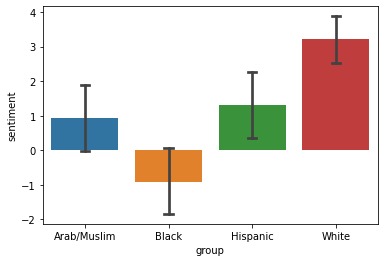

In [38]:
import seaborn
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)

In these previous plots we can see that the classifier is racist, especially for black names. Moreover, the most positive-valued names are white names. This happens because there is a racist bias in the data used to train the classifier. Therefore, the more accurate our classifier is with the data, the more it learns its undesired biases. 

The key idea to take from this is that **the model is racist because the data we used to train it is racist**. After all, the model only learns from data. 

## Discussion topics

1. Why is the model racist?

2. How could you try to solve this issue?

3. If a racist model gives better accuracy results than a non-racist model, which one would you use?

4. What other situations can you think of where biases among data can make a machine learning model discriminate among people? 

5. What other ethical problems could there emerge when working with data (i.e data privacy, anonimization,...)?

6. If you want to discover some of your ethica values you can play this game:  https://www.moralmachine.net/hl/es
